In [14]:
import timm
from timm import create_model
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer
import numpy as np
import torchvision.transforms as T
from torch import from_numpy
from torch import nn
import torch.utils.data as TUD
from nystrom_attention import NystromAttention
from tqdm import tqdm

# v6 updates

* include TransMIL implementation from Tristan

# v5 updates

* refactor code to work with bag sizes instead of bad ids
* TODO - improve the visualization of the saliency maps
* separate the encoder model and the bag aggregation model

# v4 updates
fixed to allow num_classes = 1 and use BCE loss

# v3 updates

separate the model into two sequenced models so that the encoder can be frozen

# v2 updates
We've modified the code to use pretrained models from the timm package which has far more models than available through fastai.  The cell below can show the available pretrained models in timm.

In [2]:
# this is a long list, at last check there were 1242 pretrained models
display_models = False
if display_models:
    avail_pretrained_models = timm.list_models(pretrained=True)
    len(avail_pretrained_models), avail_pretrained_models

# things to do/improve

* Improve the downloader to include encodes, decodes, one_batch so that show and summary both work (see https://docs.fast.ai/tutorial.siamese.html#preparing-the-data)
* Break the model in two: encoder and aggregator, then concatentate them with pytorch sequence.  This way we can split the model and freeze the encoder.
* Make a custom datablock for a bag of images.
* Make a flexible downloader that downloads multiple bags until we have a max number of images in the batch
* refactor to use the number of items in each bag instead of bag_ids to partition the batch of bags into individual bags

# Multiple Instance Learning - Proof of Concept

In this notebook we implement the <a href="https://arxiv.org/abs/1802.04712">"Attention-based Deep Multiple Instance Learning"</a> (by Ilse, et al) strategy for learning labels for bags of images.  In this case each bag contains 3 to 7 images from Imagenette.  Each bag is labeled as "Fish" (1) or "no Fish" (0).  

This is essentially the model from <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8463596/">"Artificial intelligence system reduces false-positive findings in the interpretation of breast ultrasound exams"</a> (referred to below as "NYU paper") so we also get saliency maps that localize the regions in the images that are important to the classification.  We will display those saliency maps as heatmaps overlaid on the images.  **We have not yet included the regularization term for the saliency maps to support more compact localization.**

For the backbone network we are using Resnet34 which is pre-trained on Imagenet.  Since the Imagenette dataset is a subset of Imagenet or backbone is already well trained for Imagenette.  All we need to do is fine tune the model a little. (The paper above uses Resnet18)

The MIL approach by Ilse, et al.  Assumes that the instances in each bag are independent of each other which clearly isn't the case for our ultrasound images (though the Imagenette images could be considered independent.)

## Future Work

* change Cross Entropy Loss to Binary Cross Entropy Loss to enable multi-class support (for lesions in ultrasounds we'd have malignant lesion (yes/no), benign lesion (yes/no) instead of simply malignant (yes/no))
* the loss functions have built-in sigmoids to normalize the inputs, but our inputs are already normalized so replace the loss functions with versions that do not include the sigmoids or softmax functions.
* include the saliency map regularization term from the NYU paper
* plot the saliency heatmaps along side each bag of images
* Try replacing the backbone and saliency map head with <a href="https://arxiv.org/abs/2106.00908">TransMIL</a> that models the correlations between instances. The attention maps might be useful for explainability visualization.

## Build Bags of Images

Create bags of images.  Each bag contains 3 to 7 images randomly sampled from Imagenette.  A bag is positive if it contains one or more images of a fish.  Otherwise the bag is negative.

Need to check the code to make sure we can handle bags with only one image.  We want to be able to test our models on public datasets with only one image per breast.

In [3]:
# change to IMAGENETTE_320 for higher resolution images
# leave it with 160 for faster training and testing
path = untar_data(URLs.IMAGENETTE_160)
path_train = path/'train'
path_val = path/'val'

In [4]:
import os

# recursively search path for files and make list
# each file appears as filename = (train|val)\\class\\fn.JPEG
# complete file name would be path/filename

def recur_list(path):
    fname = []
    for root,d_names,f_names in os.walk(path):
        root_split = root.split('\\')
        subdir = os.path.join(root_split[-2],root_split[-1])
        for f in f_names:
            suffix = f.split('.')[-1]
            if suffix == 'JPEG':
                fname.append(os.path.join(subdir, f))
    return fname

files_train = np.array(recur_list(path_train))
files_val = np.array(recur_list(path_val))

print(f'There are {len(files_train)} files in the training data')
print(f'There are {len(files_val)} files in the validation data')

There are 9469 files in the training data
There are 3925 files in the validation data


In [5]:
lbl_dict = dict(
    n01440764='fish',
    n02102040='dog',
    n02979186='stereo',
    n03000684='saw',
    n03028079='church',
    n03394916='horn',
    n03417042='truck',
    n03425413='pump',
    n03445777='ball',
    n03888257='chute'
)

labels_train = np.array([ lbl_dict[ fn.split('\\')[1] ] for fn in files_train ])
labels_val = np.array([ lbl_dict[ fn.split('\\')[1] ] for fn in files_val ])

In [6]:
# refactor this ... awkard to create lists of lists and then flatten them

def create_bags( files, labels, min_per_bag = 3, max_per_bag = 7, random_state = 42):
    '''
    input the list of (truncated) filenames and the label for each image
    output a nested list where each sublist is a list of filenames for the bag and bag_labels is a list of all the classes in the bag
    '''
    tot_instances = len(files)
    np.random.seed( seed = random_state )
    idx = np.random.permutation(tot_instances)
    
    bag_begin = 0
    rem_instances = tot_instances
    
    bag_files = []
    bag_labels = []
    bag_ids = []
    bag_sizes = []
    id = 0
    
    while rem_instances > min_per_bag:
        bag_size = np.random.randint( min_per_bag, max_per_bag + 1 )
        bag_idx = idx[ bag_begin: (bag_begin + bag_size) ]
        bag_files.append(files[ bag_idx ] )
        bag_labels.append(labels[ bag_idx ] )
        bag_ids.append(id*np.ones_like(bag_idx))
        id += 1
        bag_begin += bag_size
        rem_instances = tot_instances - bag_begin
        
    return bag_files, bag_labels, bag_ids

bags_val, bags_val_labels_all, bags_val_ids = create_bags( files_val, labels_val )
bags_train, bags_train_labels_all, bags_train_ids = create_bags( files_train, labels_train)

# the code above returns nested lists, each list contains arrays with filenames, all labels, and bag id for each of the bags
# we'll need to flatten the files list, id's list, and make a list with one label for each bag ('fish', 'no_fish')

files_train = np.concatenate( bags_train )
ids_train = np.concatenate( bags_train_ids )
labels_train = np.array( [1 if 'fish' in x else 0 for x in bags_train_labels_all] )

files_val = np.concatenate( bags_val )
ids_val = np.concatenate( bags_val_ids )
labels_val = np.array( [1 if 'fish' in x else 0 for x in bags_val_labels_all] )

## Custom Pytorch Dataset and Dataloaders

Normalizes images using Imagenet stats.  Note, the image size defaults to 160.  To change this, add imsize = ... when instantiating the datasets using BagOfImagesDataset.

In [7]:
class BagOfImagesDataset(TUD.Dataset):

  def __init__(self, filenames, directory, ids, labels, imsize = 160, normalize=True):
    self.filenames = filenames
    self.directory = directory
    self.labels = from_numpy(labels)
    self.ids = from_numpy(ids)
    self.normalize = normalize
    self.imsize = imsize
  
    # Normalize
    if normalize:
        self.tsfms = T.Compose([
        T.ToTensor(),
        T.Resize( (self.imsize, self.imsize) ),
        T.Normalize(mean=[0.485, 0.456, 0.406],std= [0.229, 0.224, 0.225])
        ])
    else:
        self.tsfms = T.Compose([
        T.ToTensor(),
        T.Resize( (self.imsize, self.imsize) )
        ])

  def __len__(self):
    return len(torch.unique(self.ids))
  
  def __getitem__(self, index):
    where_id = self.ids == index
    files_this_bag = self.filenames[ where_id ]
    data = torch.stack( [ 
        self.tsfms( Image.open( os.path.join( self.directory, fn ) ).convert("RGB") ) for fn in files_this_bag 
    ] ).cuda()

    labels = self.labels[index]
    
    return data, labels
  
  def n_features(self):
    return self.data.size(1)

def collate_custom(batch):
    batch_data = []
    batch_bag_sizes = [0] 
    batch_labels = []
  
    for sample in batch:
        batch_data.append(sample[0])
        batch_bag_sizes.append(sample[0].shape[0])
        batch_labels.append(sample[1])
  
    out_data = torch.cat(batch_data, dim = 0).cuda()
    bagsizes = torch.IntTensor(batch_bag_sizes).cuda()
    out_bag_starts = torch.cumsum(bagsizes,dim=0).cuda()
    out_labels = torch.stack(batch_labels).cuda()
    
    return (out_data, out_bag_starts), out_labels

In [8]:
num_bags_train = 1882 # <= 1882
num_bags_val = 782 # <= 782
bs = 20 # batch size

dataset_train = TUD.Subset(BagOfImagesDataset( files_train, path, ids_train, labels_train),list(range(0,num_bags_train)))
dataset_val = TUD.Subset(BagOfImagesDataset( files_val, path, ids_val, labels_val),list(range(0,num_bags_val)))
dataset_val_raw = TUD.Subset(BagOfImagesDataset( files_val, path, ids_val, labels_val, normalize = False),list(range(0,num_bags_val)))

train_dl =  TUD.DataLoader(dataset_train, batch_size=bs, collate_fn = collate_custom, drop_last=True, shuffle = True)
val_dl =    TUD.DataLoader(dataset_val, batch_size=bs, collate_fn = collate_custom, drop_last=True)

# wrap into fastai Dataloaders
dls = DataLoaders(train_dl, val_dl)

## The Model

<img src = "ilse_bag_model.png" width = "400">

Image from:
Shen, Y., Shamout, F.E., Oliver, J.R. *et al.* Artificial intelligence system reduces false-positive findings in the interpretation of breast ultrasound exams. *Nat Commun* 12, 5645 (2021). 

The input to the model is a tuple of the form

(batch of images in Torch tensor, bag_ids in Torch tensor)

The model first computes features for each image.  The features go through a weighted average to give a saliency map and the saliency maps are pooled to get pseudo-labels for each image.  Finally the pseudo-labels are aggregated into bag labels with a gated-attention mechanism.

The forward method returns only the tensor of bag labels.  The saliency maps (called CAM in the code) are returned as attributes of the model object as well as the attention scores.  It would be cleaner to return these directly in the forward method but that would have been messy with the FastAI training code and would likely require a custom loss function.

(Maybe we should go with the custom loss function to include a regularization term.)

In [9]:
# this function is used to cut off the head of a pretrained timm model and return the body
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [10]:
# input a bag of nf features from a CNN will be a tensor of 
# dimnesions bag_size x nf x h x w
#   bag_size = number of images in current bag
#   nf = number of features produced by backbone CNN (512 for resnet34)
#   h,w = dimensions of each feature
#
# output bag-level predicition, saliency maps, instance-level predictions, attention score
#  prediction is a scalar between 0 and 1
#  saliency_maps are bag_size x num_classes x h x w (squeezed to bag_size x h x w if num_classes = 1)
#  instance_level_predictions is a one-dim tensor with bag_size predictions in 0,1
#  attention scores there are bag_size of these between 0 and 1

class ABMIL_aggregate(nn.Module):
    
    def __init__(self, nf = 512, num_classes = 1, pool_patches = 3, L = 128):
        super(ABMIL_aggregate,self).__init__()
        self.nf = nf
        self.num_classes = num_classes # two for binary classification
        self.pool_patches = pool_patches # how many patches to use in predicting instance label
        self.L = L # number of latent attention features   
        
        self.saliency_layer = nn.Sequential(        
            nn.Conv2d( self.nf, self.num_classes, (1,1), bias = False),
            nn.Sigmoid() )
        
        self.attention_V = nn.Sequential(
            nn.Linear(self.nf, self.L),
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.nf, self.L),
            nn.Sigmoid()
        )

        self.attention_W = nn.Sequential(
            nn.Linear(self.L, self.num_classes),
        )
                    
    def forward(self, h):
        # input is a tensor with a bag of features, dim = bag_size x nf x h x w
    
        saliency_maps = self.saliency_layer(h)
        map_flatten = saliency_maps.flatten(start_dim = -2, end_dim = -1)
        selected_area = map_flatten.topk(self.pool_patches, dim=2)[0]
        yhat_instance = selected_area.mean(dim=2).squeeze()
        
        # gated-attention
        v = torch.max( h, dim = 2).values # begin maxpool
        v = torch.max( v, dim = 2).values # maxpool complete
        A_V = self.attention_V(v) 
        A_U = self.attention_U(v) 
        attention_scores = nn.functional.softmax(
            self.attention_W(A_V * A_U).squeeze(), dim = 0 )
        
        # aggreate individual predictions to get bag prediciton
        yhat_bag = (attention_scores * yhat_instance).sum(dim=0)
       
        return yhat_bag, saliency_maps, yhat_instance, attention_scores

In [11]:
# MAYBE arrange this so that if bag_starts is empty, it is assumed that the input
# data consists of one bag of images

class EmbeddingBagModel(nn.Module):
    
    def __init__(self, encoder, aggregator, num_classes = 1):
        super(EmbeddingBagModel,self).__init__()
        self.encoder = encoder
        self.aggregator = aggregator
        self.num_classes = num_classes
                    
    def forward(self, input):
        # input should be a tuple of the form (data,bag_starts)
        x = input[0]
        bag_sizes = input[1]
        
        # compute the features using encoder network
        h = self.encoder(x)
        
        # loop over the bags and compute yhat_bag, etc. for each
        num_bags = bag_sizes.shape[0]-1
        saliency_maps, yhat_instances, attention_scores = [],[],[]
        
        yhat_bags = torch.empty(num_bags,self.num_classes).cuda()

        for j in range(num_bags):
            start, end = bag_sizes[j], bag_sizes[j+1]
            
            yhat_tmp, sm, yhat_ins, att_sc = self.aggregator(h[start:end])
            
            yhat_bags[j] = yhat_tmp
            saliency_maps.append(sm)
            yhat_instances.append(yhat_ins)
            attention_scores.append(att_sc)
            
        # converts lists to tensors (this seems optional)
        self.saliency_maps = torch.cat(saliency_maps,dim=0).cuda()
        self.yhat_instances = torch.cat(yhat_instances,dim=0).cuda()
        self.attention_scores = torch.cat(attention_scores,dim=0).cuda()
       
        return yhat_bags.squeeze()

## Regularizing the Saliency Maps

We use a callback to add the regularization term to the loss function.  The regularization is supposed to encourage the saliency maps to stay localized.

**Definitely not certain this is implemented correctly.  Need to think it through.**

In [12]:
# "The regularization term |A| is basically model.saliency_maps.mean()" -from github repo
class L1RegCallback(Callback):
    def __init__(self, reglambda = 0.0001):
        self.reglambda = reglambda
       
    def after_loss(self):
        self.learn.loss += self.reglambda * self.learn.model.saliency_maps.mean()

# set regularization parameter
reg_lambda = 0.001

## Tristan's Pytorch Training Loop

In [40]:

# Config Parameters
model_name = 'Tristan1'
env = '.' # string to main working directory
img_size = 160
batch_size = 3
min_bag_size = 3
max_bag_size = 15
epochs = 5
lr = 0.001

# choose encoder
encoder = create_timm_body('resnet18')
nf = num_features_model( nn.Sequential(*encoder.children()))
    
# bag aggregator
aggregator = ABMIL_aggregate( nf = nf, num_classes = 1, pool_patches = 3, L = 128)

# total model
bagmodel = EmbeddingBagModel(encoder, aggregator).cuda()
total_params = sum(p.numel() for p in bagmodel.parameters())
print(f"Total Parameters: {total_params}")
                
optimizer = Adam(bagmodel.parameters(), lr=lr)
loss_func = nn.BCELoss()
train_losses_over_epochs = []
valid_losses_over_epochs = []
epoch_start = 0
    
# Check if the model already exists
model_folder = f"{env}/models/{model_name}/"
model_path = f"{model_folder}/{model_name}.pth"
optimizer_path = f"{model_folder}/{model_name}_optimizer.pth"
stats_path = f"{model_folder}/{model_name}_stats.pkl"
    
if os.path.exists(model_path):
    bagmodel.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))
    print(f"Loaded pre-existing model from {model_name}")

    with open(stats_path, 'rb') as f:
        saved_stats = pickle.load(f)
        train_losses_over_epochs = saved_stats['train_losses']
        valid_losses_over_epochs = saved_stats['valid_losses']
        epoch_start = saved_stats['epoch']
        val_acc_best = saved_stats.get('val_acc', -1)  # If 'val_acc' does not exist, default to -1
else:
    print(f"{model_name} does not exist, creating new instance")
    os.makedirs(model_folder, exist_ok=True)
    val_acc_best = -1 
    
    # Training loop
    for epoch in range(epoch_start, epochs):
        # Training phase
        bagmodel.train()
        total_loss = 0.0
        total_acc = 0
        total = 0
        correct = 0
        for (data, yb) in tqdm(train_dl, total=len(train_dl)): 
            (xb, bag_sizes), yb = data, yb.float().cuda() #xb is a tuple in JB implementation
            
            optimizer.zero_grad()
            
            #outputs = bagmodel(xb).squeeze(dim=1)
            outputs = bagmodel((xb,bag_sizes))
            loss = loss_func(outputs, yb)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xb)
            predicted = torch.round(outputs).squeeze()
            total += yb.size(0)
            correct += predicted.eq(yb.squeeze()).sum().item()

        train_loss = total_loss / total
        train_acc = correct / total


        # Evaluation phase
        bagmodel.eval()
        total_val_loss = 0.0
        total_val_acc = 0.0
        total = 0
        correct = 0
        all_targs = []
        all_preds = []
        with torch.no_grad():
            for (data, yb) in tqdm(val_dl, total=len(val_dl)): 
                (xb, bag_sizes), yb = data, yb.float().cuda()

                #outputs = bagmodel((xb,bag_sizes)).squeeze(dim=1)
                outputs = bagmodel((xb,bag_sizes))
                loss = loss_func(outputs, yb)
                
                total_val_loss += loss.item() * len(xb)
                predicted = torch.round(outputs).squeeze() 
                total += yb.size(0)
                correct += predicted.eq(yb.squeeze()).sum().item()
                
                # Confusion Matrix data
                all_targs.extend(yb.cpu().numpy())
                if len(predicted.size()) == 0:
                    predicted = predicted.view(1)
                all_preds.extend(predicted.cpu().detach().numpy())

        val_loss = total_val_loss / total
        val_acc = correct / total
        
        train_losses_over_epochs.append(train_loss)
        valid_losses_over_epochs.append(val_loss)
        
        print(f"Epoch {epoch+1} | Acc   | Loss")
        print(f"Train   | {train_acc:.4f} | {train_loss:.4f}")
        print(f"Val     | {val_acc:.4f} | {val_loss:.4f}")
        
        # Save the model
        if val_acc > val_acc_best:
            val_acc_best = val_acc  # Update the best validation accuracy
            #save_state(epoch, train_acc, val_acc, model_folder, model_name, bagmodel, optimizer, all_targs, all_preds, train_losses_over_epochs, valid_losses_over_epochs)
            print("Saved checkpoint due to improved val_acc",val_acc)

Total Parameters: 11308481
Tristan1 does not exist, creating new instance


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.65it/s]


Epoch 1 | Acc   | Loss
Train   | 0.9149 | 1.2420
Val     | 0.9244 | 1.0839
Saved checkpoint due to improved val_acc 0.9243589743589744


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.65it/s]


Epoch 2 | Acc   | Loss
Train   | 0.9755 | 0.3622
Val     | 0.9474 | 0.7978
Saved checkpoint due to improved val_acc 0.9474358974358974


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.67it/s]


Epoch 3 | Acc   | Loss
Train   | 0.9931 | 0.0902
Val     | 0.9410 | 1.2697


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.50it/s]


Epoch 4 | Acc   | Loss
Train   | 0.9926 | 0.1224
Val     | 0.9077 | 1.6964


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.56it/s]

Epoch 5 | Acc   | Loss
Train   | 0.9814 | 0.2325
Val     | 0.9577 | 0.6566
Saved checkpoint due to improved val_acc 0.9576923076923077


In [42]:
bagmodel.attention_scores

tensor([1.0311e-02, 2.5699e-01, 2.0155e-02, 5.9497e-01, 1.1756e-01, 2.4782e-01,
        8.8348e-02, 5.5559e-02, 1.6900e-01, 3.9318e-01, 4.6098e-02, 6.8254e-01,
        2.7269e-03, 3.1473e-01, 4.4176e-05, 3.8668e-05, 1.8182e-06, 6.5106e-05,
        9.9985e-01, 1.4464e-06, 2.2605e-06, 5.5749e-06, 1.0031e-05, 6.9041e-08,
        5.3589e-06, 7.4472e-06, 9.9997e-01, 1.4224e-01, 1.8114e-03, 8.5580e-01,
        1.4885e-04, 9.3415e-01, 5.4095e-02, 1.1753e-02, 2.1497e-01, 1.0360e-01,
        6.3470e-01, 1.3017e-03, 4.5425e-02, 2.3155e-05, 1.2616e-05, 9.9994e-01,
        4.9827e-08, 1.0580e-05, 8.7180e-06, 1.6790e-08, 1.0000e+00, 2.0558e-06,
        3.7514e-08, 2.8725e-07, 2.5329e-03, 1.2618e-04, 5.4288e-03, 9.8090e-01,
        5.7869e-03, 5.2246e-03, 4.9508e-01, 2.6661e-01, 2.0646e-01, 3.1854e-02,
        4.0799e-01, 4.8938e-02, 5.2144e-04, 7.5481e-02, 5.2609e-02, 1.6192e-02,
        3.9827e-01, 2.4299e-05, 7.1043e-01, 2.6240e-01, 1.2314e-02, 2.3379e-03,
        1.2488e-02, 4.2706e-06, 2.1086e-

In [43]:
bagmodel.yhat_instances

tensor([1.0925e-02, 8.7531e-04, 4.9870e-03, 2.1267e-04, 4.6967e-03, 7.1597e-04,
        5.2390e-04, 5.5066e-03, 8.0350e-03, 3.8456e-02, 1.9501e-02, 2.2565e-04,
        1.5121e-01, 2.7935e-03, 6.9793e-05, 2.8648e-03, 6.0982e-02, 6.8058e-04,
        1.0000e+00, 3.8107e-02, 5.9635e-03, 1.8676e-03, 5.1888e-04, 2.5105e-02,
        5.0474e-03, 1.4582e-02, 1.0000e+00, 4.1008e-04, 4.2033e-01, 1.9373e-04,
        1.8089e-01, 6.4848e-03, 5.0963e-02, 3.8233e-02, 4.2901e-04, 1.8035e-02,
        3.9368e-03, 7.4822e-02, 9.2246e-02, 2.8604e-02, 4.1316e-03, 1.0000e+00,
        5.4704e-02, 2.2200e-03, 9.2124e-04, 2.2816e-01, 1.0000e+00, 4.0460e-01,
        2.4356e-01, 6.7659e-02, 9.7508e-04, 2.1625e-02, 1.1262e-04, 9.9552e-01,
        4.9735e-03, 1.0965e-04, 2.6216e-04, 8.6267e-04, 3.9065e-03, 1.2572e-02,
        8.1191e-05, 8.4266e-02, 1.8821e-01, 8.9716e-03, 3.5140e-03, 6.5864e-04,
        1.9245e-03, 8.4910e-02, 9.4454e-01, 9.4796e-01, 7.9169e-04, 8.6209e-04,
        1.5854e-02, 2.0417e-01, 2.7502e-

In [ ]:
model_name = 'XYZ'
env = '.'
model_folder = f"{env}/models/{model_name}/"
model_folder

## FastAI Training

**FIXED - Pretty sure the body of the model is not frozen when using the timm models, see https://walkwithfastai.com/EfficientNet_and_Custom_Weights for a discussion of how to freeze**  Can't display learn.summary() to see which layers are frozen because one_batch() isn't implemented in the downloader.  I think we probably want to implement the encoder and aggregator as separate models and then do something like model = nn.Sequential(encoder, aggregator) so that we can easily split the model and freeze part of it.

We use FastAI's learning rate finder.  For this toy problem very little training is required.  The backbone is pretrained on Imagenet and Imagenette is a subset.  We freeze the backbone and train for a few epochs to adjust the attention weights, then we unfreeze the backbone and train for a few more epochs to ensure everything works together.  We could probably do away with the second phase of training for this toy problem, but we'd need much more comprehensive training for the breast ultrasound images since they're from a very different distribution than Imagenet.

In [51]:
# suggest you use resnet18 to get |things working since it's smaller and faster

# CHOOSE THE ENCODER
#timm_arch = 'efficientnet_b1' # got about 95% and the saliency map likely needs to be retuned
#timm_arch = 'resnet18' # 96-97%
timm_arch = 'resnet18' # gets about 98% accuracy at the bag-level
#timm_arch = 'resnet152' # about 99+% accuracy at bag-level

num_classes = 1
pre_trained = False

encoder = create_timm_body(timm_arch, pretrained = pre_trained)
nf = num_features_model( nn.Sequential(*encoder.children()))

# CHOOSE THE AGGREGATOR
agg_model = 'TransMIL' 

if agg_model == 'ABMIL':
    aggregator = ABMIL_aggregate( nf = nf, num_classes = num_classes, pool_patches = 3, L = 128)
    callbacks = [L1RegCallback(reg_lambda)]
    loss = BCELossFlat()
    ce_loss = CrossEntropyLossFlat()
    bagmodel = EmbeddingBagModel(encoder, aggregator).cuda()
elif agg_model == 'TransMIL':
    aggregator = TransMIL(dim_in=nf, dim_hid=512, n_classes=num_classes)
    callbacks = []
    loss = BCEWithLogitsLossFlat()
    bagmodel = EmbeddingBagModel2(encoder, aggregator).cuda()


def ilse_splitter(model):
    # split the model so that freeze works on the backbone
    p = params(model)
    num_body = len( params(model.encoder) )
    num_total = len(p)
    return [p[0:num_body], p[(num_body+1):num_total]]

# BCE loss doesn't encode the predictions, so 
# we include it in the accuracy
def accuracy_thresh(inp, targ, thresh=0.5):
    "Compute accuracy when `inp` and `targ` are the same size."
    inp,targ = flatten_check(inp,targ)
    return ((inp>thresh)==targ.bool()).float().mean()

if num_classes == 1:
    learn = Learner(dls,bagmodel, loss_func=loss,splitter=ilse_splitter,metrics = accuracy_thresh, cbs = callbacks )
else:
    learn = Learner(dls,bagmodel, loss_func=ce_loss,splitter=ilse_splitter,metrics = accuracy_thresh, cbs = callbacks )

if pre_trained:
    learn.freeze()
else:
    learn.unfreeze()

In [52]:
# how many frozen / unfrozen parameters
frozen_parameters = filter(lambda p: not p.requires_grad, learn.model.parameters())
frozen = sum([np.prod(p.size()) for p in frozen_parameters])
unfrozen_parameters = filter(lambda p: p.requires_grad, learn.model.parameters())
unfrozen = sum([np.prod(p.size()) for p in unfrozen_parameters])
print(f'There are {frozen} frozen parameters and {unfrozen} unfrozen parameters')

There are 0 frozen parameters and 13586001 unfrozen parameters


SuggestedLRs(valley=0.00013182566908653826)

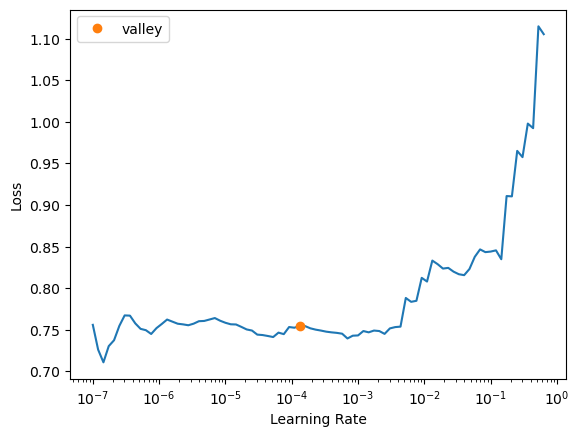

In [53]:
# learning rate finder often fails here, especially with very small batches
learn.lr_find()

In [54]:
lr = 0.00001
#learn.fit_one_cycle(20,lr)
learn.fit(50,lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.686547,0.666751,0.611538,01:17
1,0.670784,0.657594,0.611538,01:18
2,0.658263,0.648362,0.611538,01:18
3,0.652846,0.641232,0.611538,01:18
4,0.643677,0.641400,0.611538,01:17
5,0.634514,0.638340,0.615385,01:15
6,0.626937,0.634217,0.614103,01:15
7,0.615243,0.635434,0.629487,01:16
8,0.606858,0.632484,0.633333,01:17
9,0.591230,0.640894,0.655128,01:16


In [22]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max = slice(lr/400,lr/4))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.006043,0.361515,0.925641,01:24


KeyboardInterrupt: 

yhat_bag, yhat_instance tensor(0.0060, device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.2070, 0.0075, 0.0429, 0.0010], device='cuda:0',
       grad_fn=<CatBackward0>)


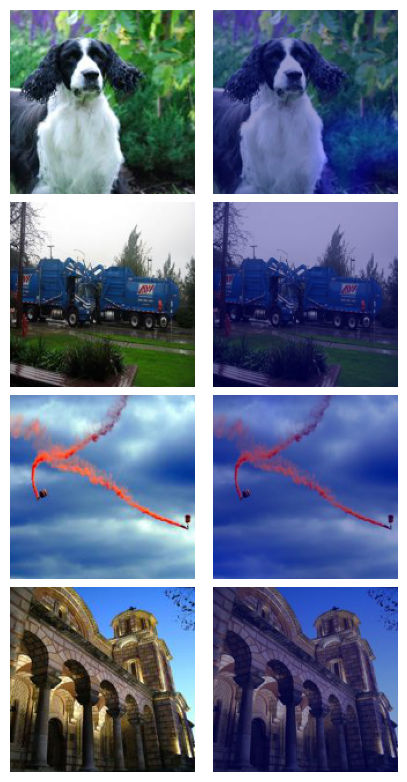

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.transforms import Resize
import cv2

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def predict_plot2(dataset, dataset_raw, learner, index = None, vis_type = 1, plot_cam = False, print_score = False, print_instances = False):
    # dataset is the normalized images
    # dataset_raw is unnormalized, shouldn't need both
    if index is None:
        index = np.random.randint( len(dataset) )
        
    # make prediction with trained model in learner
    bag_images, bag_label = dataset[index]
    B,C,H,W = bag_images.shape
    num_images = B
    bag_starts = torch.IntTensor([0,num_images])
    yhat_bag = learner.model( (bag_images, bag_starts) )
    #cam = learn.model.saliency_map[:,1,:,:] # only take the 2nd class for positive
    cam = learn.model.saliency_maps
    yhat_instance = learn.model.yhat_instances
    print('yhat_bag, yhat_instance',yhat_bag,yhat_instance)
    bag_images_raw,_ = dataset_raw[index]
    
    #cmap = plt.cm.get_cmap("jet")
    cmap = plt.colormaps["jet"]
    fig,axs = plt.subplots(B,2,figsize=(5,2.5*B),gridspec_kw = {'wspace':0.1, 'hspace':0})
    for j in range(B):
        img_numpy = bag_images_raw[j].cpu().detach().permute(1,2,0).numpy()
        axs[j,0].imshow( img_numpy )
        axs[j,0].axis('off')
        axs[j,1].imshow( img_numpy )
        axs[j,1].axis('off')
        saliency = cam[j].squeeze().cpu().detach().numpy()
        if vis_type == 1:
            saliency[ saliency < np.percentile(saliency,90) ] = 0.0
            axs[j,1].imshow(cv2.resize(saliency,[H,W]),alpha=0.4,cmap=cmap,clim=[0.0,1.0])
        elif vis_type == 2:
            saliency = cv2.resize(saliency,[H,W])
            contours,_ = cv2.findContours(image=saliency, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
            cv2.drawContours(image=img_numpy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
                


# change index to view different bags
predict_plot2(dataset_val, dataset_val_raw, learn, index=36, vis_type=1)

In [23]:
dataset_val[0][0].shape

torch.Size([6, 3, 160, 160])

In [10]:
np.sqrt(1.5)

1.224744871391589

In [15]:
x = torch.rand(7,3,160,160).cuda()
h = encoder(x)

In [17]:
yhat_bag, saliency_maps, yhat_instance, attention_scores = aggregator(h)

In [24]:
attention_scores

tensor([0.4618, 0.4674, 0.4666, 0.4652, 0.4627, 0.4611, 0.4819],
       device='cuda:0', grad_fn=<SqueezeBackward0>)